In [1]:
# Define libraries
import pandas as pd
import numpy as np
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.pipeline import Pipeline  
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Load your data
df = pd.read_csv('data/final_merged_100users.csv')

In [3]:
# Define categorical and numerical columns
categorical_features = ['Use Chip', 'Merchant State', 'Errors?', 'time_of_day']
numerical_features = [
    'Amount', 'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt', 
    'FICO Score', 'Num Credit Cards', 'Has Chip', 'Cards Issued', 'International', 
    'Online', 'Age_at_transaction', 'income_to_debt', 'day_of_week', 'distances'
]

In [4]:
# Define the target variable
target = 'Is Fraud?'

In [5]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model = RandomForestClassifier(random_state=42)

# Create the pipeline with RandomUnderSampler and preprocessing
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('undersampler', RandomUnderSampler(random_state=42)),
        ('classifier', model)
    ])

In [6]:
# Split the data into training and testing sets
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Perform grid search with the pipeline, reduced n_jobs, and error_score='raise' for detailed errors
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1, error_score='raise')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Amount',
                                                                          'Per '
                                                                          'Capita '
                                                                          'Income '
                                                                          '- '
                                                                          'Zipcode',
                                                                          'Yearly '
                                                                          'Income '
                                                                          '- '
                                                                          'Person',
                                                                          'Total '
                                                                          'Debt',
                                                                          'FICO '
                                                                          'Score',
                                                                          'Num '
                                                                          'Credit '
                                                                          'Cards',
                                                                          'Has '
                                                                          'Chip',
                                                                          'Cards '...
                                                                          'Chip',
                                                                          'Merchant '
                                                                          'State',
                                                                          'Errors?',
                                                                          'time_of_day'])])),
                                       ('undersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [10]:
# Best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("\nBest Parameters:")
print(best_params)


Best Parameters:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [11]:
# Save the model
model_filename = 'trained_model100_randomforest.joblib'
joblib.dump(best_estimator, model_filename)
print(f"Model saved to {model_filename}")

# Load the model
loaded_model = joblib.load(model_filename)
print("Model loaded successfully")

Model saved to trained_model100_randomforest.joblib
Model loaded successfully


In [12]:
# Predict using the loaded model
y_pred_loaded = loaded_model.predict(X_test)

# Evaluation
print('\nClassification Report (Random Forest):')
print(classification_report(y_test, y_pred_loaded))
print('Confusion Matrix (Random Forest):')
print(confusion_matrix(y_test, y_pred_loaded))
print('Accuracy Score (Random Forest):')
print(accuracy_score(y_test, y_pred_loaded))


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    240503
           1       0.01      0.89      0.02       224

    accuracy                           0.93    240727
   macro avg       0.51      0.91      0.49    240727
weighted avg       1.00      0.93      0.96    240727

Confusion Matrix (Random Forest):
[[222838  17665]
 [    24    200]]
Accuracy Score (Random Forest):
0.9265184212821993


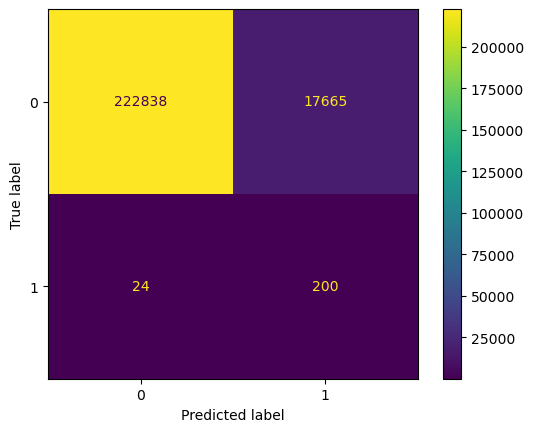

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting on the training set
y_test_pred = loaded_model.predict(X_test)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()